In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten ,MaxPooling2D , GlobalAvgPool2D,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [24]:
path  = "/kaggle/input/fer2013/"

In [25]:
image_filenames = glob.glob(os.path.join(path,'**/*.jpg'), recursive=True)

# create an info dataframe
df = pd.DataFrame({'filename': image_filenames})
df['partition'] = df['filename'].apply(lambda x: x.split(os.sep)[-3])
df['label'] = df['filename'].apply(lambda x: x.split(os.sep)[-2])

df

,filename,partition,label
0,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
1,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
2,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
3,/kaggle/input/fer2013/test/surprise/PublicTest...,test,surprise
4,/kaggle/input/fer2013/test/surprise/PrivateTes...,test,surprise
...,...,...,...
35882,/kaggle/input/fer2013/train/happy/Training_188...,train,happy
35883,/kaggle/input/fer2013/train/happy/Training_165...,train,happy
35884,/kaggle/input/fer2013/train/happy/Training_108...,train,happy
35885,/kaggle/input/fer2013/train/happy/Training_304...,train,happy


In [26]:
image_generator=ImageDataGenerator(rescale=1/255 )

#image_generator_valid = ImageDataGenerator(rescale=1/255 )

Training = image_generator.flow_from_directory('/kaggle/input/fer2013/train',   
    batch_size=128,class_mode='categorical' , target_size=(224, 224))


Test = image_generator.flow_from_directory('/kaggle/input/fer2013/test' , 
    batch_size=128,class_mode='categorical' , target_size=(224, 224))

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [30]:
mobile_net = MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = "imagenet",
    classes = 7
)


In [28]:
#Model Summary
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [32]:
x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(7, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [33]:
for layer in model.layers[:15]:
    layer.trainable = False

In [19]:
model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,1024)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(7, activation='softmax'))

In [34]:
image_generatorly_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    image_generatorly_stopping,
    lr_scheduler,
]

In [35]:
epochs = 40


model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
)

history = model.fit_generator(
    Training,
    validation_data=Test,
    epochs=epochs,
    callbacks=callbacks
)

/tmp/ipykernel_3738/69850970.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40


I0000 00:00:1708171104.086113    3791 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - 93s 368ms/step - loss: 1.3995 - accuracy: 0.5118 - val_loss: 1.3568 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 2/40
225/225 [==============================] - 82s 365ms/step - loss: 0.9700 - accuracy: 0.6473 - val_loss: 1.0852 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 3/40
225/225 [==============================] - 86s 384ms/step - loss: 0.7938 - accuracy: 0.7137 - val_loss: 1.1050 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 4/40
225/225 [==============================] - 84s 371ms/step - loss: 0.6233 - accuracy: 0.7748 - val_loss: 1.3243 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 5/40
225/225 [==============================] - 82s 365ms/step - loss: 0.4944 - accuracy: 0.8264 - val_loss: 1.2468 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 6/40
225/225 [==============================] - 87s 387ms/step - loss: 0.3514 - accuracy: 0.8808 - val_loss: 1.3793 - val_accuracy: 0.5751 - lr: 0.0010
Epoch 7/40
225/225 [==============================] - ETA: 0s -

In [36]:
# Loading the best fit model 
from keras.models import load_model
model.save('Mobile_model.h5')
model = load_model("Mobile_model.h5")
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
# imports 
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
cls_wgts = class_weight.compute_class_weight('balanced',
                                             sorted(np.unique(Traning)),
                                             y_train)
# dict mapping
cls_wgts = {i : cls_wgts[i] for i, label in enumerate(sorted(np.unique(y_train)))}

In [37]:
score = model.evaluate(Test)
print(score)

57/57 [==============================] - 17s 296ms/step - loss: 1.4025 - accuracy: 0.6840
[1.402542233467102, 0.684034526348114]


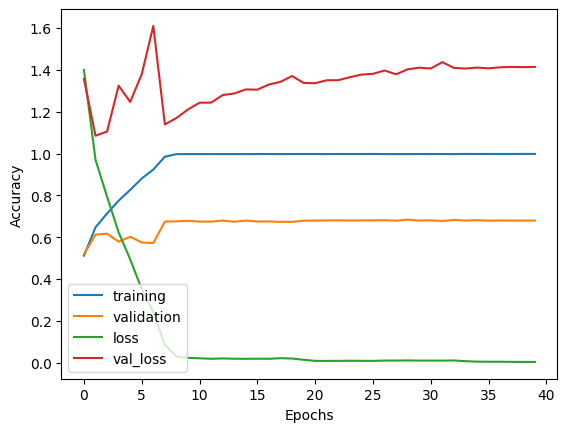

In [38]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.plot(history.history["loss"],label='loss')
plt.plot(history.history["val_loss"],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 1s 605ms/step


Text(0.5, 1.0, 'happy')

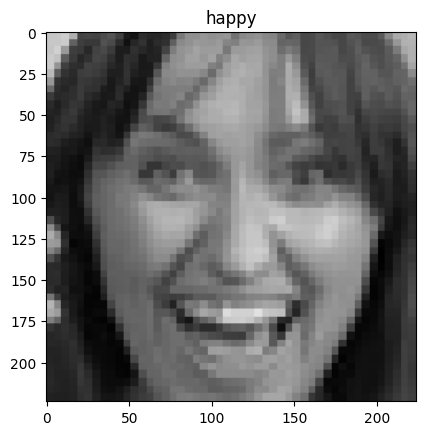

In [39]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[1],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[1])
plt.title(ls[pred])

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'angry')

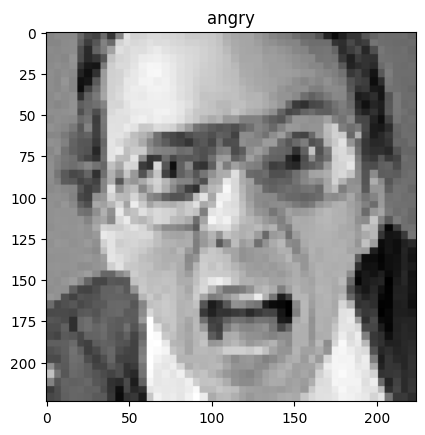

In [42]:
images,labels=Test.next()
pred=np.argmax(model.predict(tf.expand_dims(images[50],axis=0)))

ls = list(Test.class_indices.keys())

plt.imshow(images[50])
plt.title(ls[pred])